In [1]:
import networkx as nx
import numpy as np
import pickle
from parser import *
import os
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.signal import convolve2d

In [2]:
data_dir = "../data/L_32/"
dmrg_data_dir = "../data/dmrg/L_32/"
W_list = [0.0001] + list(range(1,11))
num_W = len(W_list)
num_dis = 100
num_energies = 10
num_params = 9

In [3]:
def get_mera_fname(W, e, dis):
    return "{}W_{}/epsilon_{:02}_{:02}.txt".format(data_dir, W, e, dis)

def get_dmrg_fname(W, dis):
    return "{}W_{}/epsilon_{:02}.txt".format(dmrg_data_dir, W, dis)

In [12]:
def load_diagnostics(fname):
    E_dict = {}
    with open(fname, 'r') as fp:
        data = fp.readlines()[:-1]
        energies = np.array(data[-4].split()[2:]).astype(float)
        print(energies)
        e_diffs = energies[1:] - energies[:-1]
        print(e_diffs)
        spacings = [min(e_diffs[i:i+2])/max(e_diffs[i:i+2]) for i in range(len(e_diffs)-2)]
        print(spacings)
        ll = data[-1].split()
        E = float(ll[2])
        var = float(ll[3])
        EE = float(ll[4])
        r = np.mean(spacings)        
    return E, var, EE, r

In [5]:
def get_dmrg_minmax_energies(fname):
    with open(fname, 'r') as fp:
        data = fp.readlines()[-1].split()
        return float(data[0]), float(data[1])
    
def get_mera_minmax_energies(W, dis):
    E_min, _,_,_ = load_diagnostics(get_mera_fname(W, 0, dis))
    E_max, _,_,_ = load_diagnostics(get_mera_fname(W, num_energies-1, dis))
    return E_min, E_max

In [6]:
def get_lists(flattened_data):
    return [flattened_data[:,i] for i in range(num_params)]

def smooth_data(arr, N=10):
    return np.convolve(arr, np.ones((N,))/N, mode='valid')

def smooth_data2d(arr, N=3):
    return convolve2d(arr, np.ones((N,N))/(N*N), mode='valid')

def get_sorted_data(flattened_data, x_idx):
    list_arr = get_lists(flattened_data)
    sorted_arr = [list_arr[x_idx]] + list_arr
    sorted_arr = list(zip(*sorted(zip(*sorted_arr))))
    return sorted_arr[1:]

In [7]:
all_data = np.zeros((len(W_list), num_dis, num_energies, num_params))
for W_idx, W in enumerate(W_list):
    for dis in range(num_dis):
        for e in range(num_energies):
            mera_fn = get_mera_fname(W, e, dis)
            dmrg_fn = get_dmrg_fname(W, dis)
            E, var, EE, r = load_diagnostics(mera_fn)
            E_min_dmrg, E_max_dmrg = get_dmrg_minmax_energies(dmrg_fn)
            E_min_mera, E_max_mera = get_mera_minmax_energies(W, dis)
            ep_mera = (E - E_min_mera)/(E_max_mera - E_min_mera)
            ep_dmrg = (E - E_min_dmrg)/(E_max_dmrg - E_min_dmrg)
            
            all_data[W_idx][dis][e][:] = np.array([E, var, EE, r, ep_mera, ep_dmrg, W, dis, e])

In [ ]:
# plots for constant epsilon
%matplotlib notebook
for i, W in enumerate([0.0001, 4, 10]):
        dis_data = all_data[i,0,:,:].reshape(num_energies, num_params)
        pl = get_sorted_data(dis_data, 5)
        plt.plot(pl[5], pl[0], label="W={}".format(W))
        #x_list, y_list = get_2arr_from_data(dis_data, 5, 0)
        #plt.plot(smooth_data(x_list), smooth_data(y_list), label="dis={}".format(dis))
        plt.xlabel(r"$\epsilon_{dmrg}$")
        plt.ylabel("energy")
        plt.legend(loc="best")

<IPython.core.display.Javascript object>


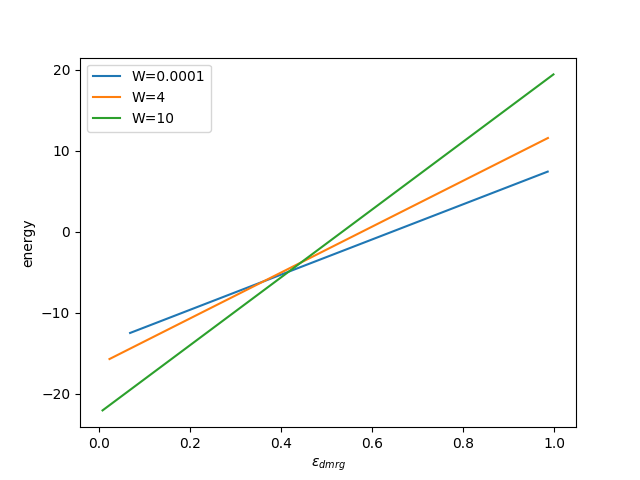

In [8]:
# plots for constant disorder
%matplotlib notebook
for dis in [4]:
    for i, W in enumerate([0.0001, 4, 10]):
        dis_data = all_data[i,dis,:,:].reshape(num_energies, num_params)
        pl = get_sorted_data(dis_data, 5)
        plt.plot(pl[5], pl[0], label="W={}".format(W))
        #x_list, y_list = get_2arr_from_data(dis_data, 5, 0)
        #plt.plot(smooth_data(x_list), smooth_data(y_list), label="dis={}".format(dis))
        plt.xlabel(r"$\epsilon_{dmrg}$")
        plt.ylabel("energy")
        plt.legend(loc="best")


<IPython.core.display.Javascript object>


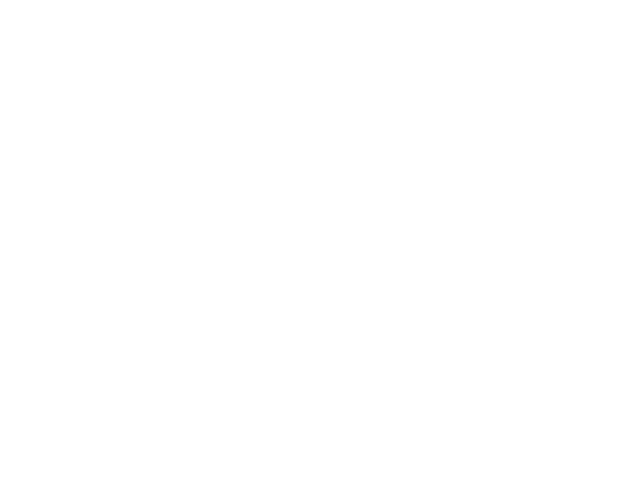

NameError: name 'get_2arr_from_data' is not defined

In [11]:
# plots for constant W
%matplotlib notebook
plt.subplot(2,1,1)
for W in [1]:
    W_data = all_data[W].reshape(num_dis*num_energies, num_params)
    pl = get_lists(W_data)
    plt.scatter(pl[4], pl[1], s = 1)
    x_list, y_list = get_2arr_from_data(W_data, 4, 1)
    plt.plot(smooth_data(x_list), smooth_data(y_list), 'r', label="W=1")
    plt.xlabel(r"$\epsilon_{mera}$")
    plt.ylabel("variance")
    plt.legend(loc="best")
plt.subplot(2,1,2)
for W in [1]:
    W_data = all_data[W].reshape(num_dis*num_energies, num_params)
    var_list = W_data[:,1]
    ep_dmrg = W_data[:,5]
    plt.scatter(ep_dmrg, var_list, s = 1)
    x_list, y_list = get_2arr_from_data(W_data, 5, 1)
    plt.plot(smooth_data(x_list), smooth_data(y_list), 'r', label="W=1")
    plt.xlabel(r"$\epsilon_{dmrg}$")
    plt.ylabel("variance")
    plt.legend(loc="best")
plt.show()

<IPython.core.display.Javascript object>


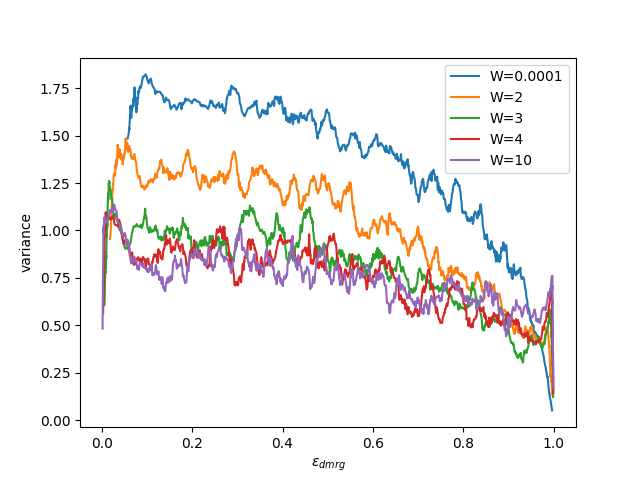

In [19]:
%matplotlib notebook
N = 20
for i, W in enumerate([0.0001, 2, 3, 4, 10]):
    W_data = all_data[i].reshape(num_dis*num_energies, num_params)
    x_list, y_list = get_2arr_from_data(W_data, 5, 1)
    plt.plot(smooth_data(x_list, N), smooth_data(y_list, N), label="W={}".format(W))

plt.xlabel(r"$\epsilon_{dmrg}$")
plt.ylabel("variance")
plt.legend(loc="best")
plt.show()

<IPython.core.display.Javascript object>


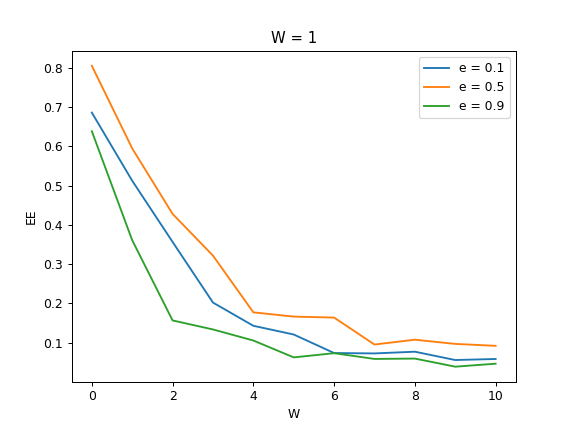

In [22]:
# plots for constant energy
%matplotlib notebook
for r in [0.1, 0.5, 0.9]:
    EE_mera = np.zeros(num_W)
    for dis in range(num_dis):
        e = int(round(r*(num_energies-1)))
        e_data = all_data[:,dis,e].reshape(num_W, num_params)
        EE_mera += np.array(e_data[:,2])
        w_list = e_data[:,6]
    EE_mera /= num_dis
    plt.plot(w_list, EE_mera, label="e = {}".format(r))
plt.title("W = {}".format(W))
plt.xlabel("W")
plt.ylabel("EE")
#plt.ylim(0,1)
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


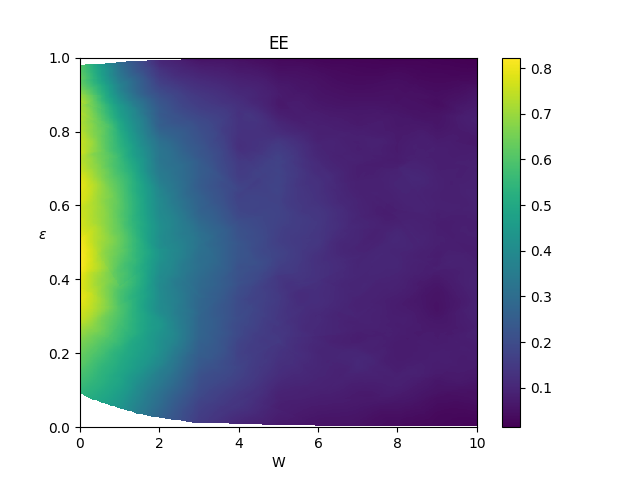

<IPython.core.display.Javascript object>


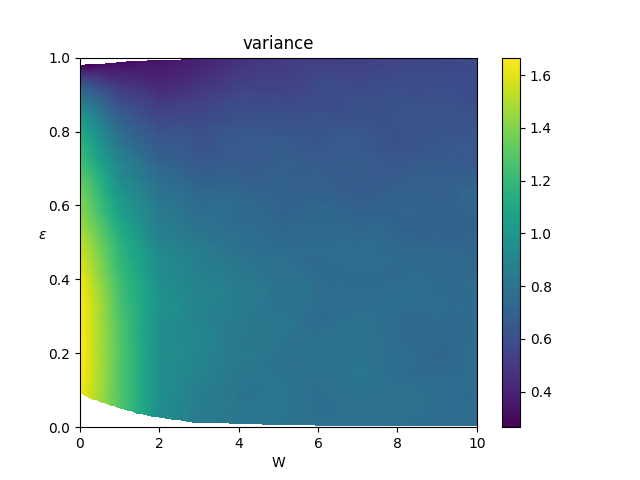

<IPython.core.display.Javascript object>


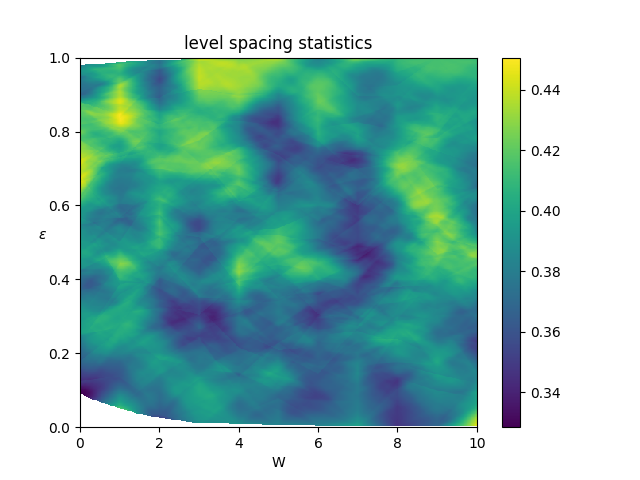

In [13]:
%matplotlib notebook
Nx, Ny = 500, 500
grid_x, grid_y = np.mgrid[0:10:Nx*1j, 0:1:Ny*1j]

EE_grid = np.zeros((Nx, Ny))
var_grid = np.zeros((Nx, Ny))
r_grid = np.zeros((Nx, Ny))

for dis in range(num_dis):
    # E, var, EE, r, ep_mera, ep_dmrg, W, dis, e
    flattened_data = all_data[:,dis,:].reshape([num_W*num_energies, num_params])
    pl = get_lists(flattened_data)
    
    W_list   = pl[6]
    ep_list  = pl[5]
    EE_list  = pl[2]
    var_list = pl[1]
    r_list   = pl[3]
    
    EE_grid  += griddata(list(zip(W_list, ep_list)), EE_list,  (grid_x, grid_y), 'linear')
    var_grid += griddata(list(zip(W_list, ep_list)), var_list, (grid_x, grid_y), 'linear')
    r_grid   += griddata(list(zip(W_list, ep_list)), r_list,   (grid_x, grid_y), 'linear')

    #plt.scatter(W_list, ep_list, s=1)
grid_list = [EE_grid/num_dis, var_grid/num_dis, r_grid/num_dis]
#grid_list = [smooth_data2d(g, 3) for g in grid_list]

plt.figure()
plt.imshow(grid_list[0].T, extent=(0,10,0,1), origin='lower', aspect='auto')
plt.ylabel(r"$\varepsilon$", rotation=0)
plt.xlabel("W")
plt.title("EE")
plt.colorbar()

plt.figure()
plt.imshow(grid_list[1].T, extent=(0,10,0,1), origin='lower', aspect='auto')
plt.ylabel(r"$\varepsilon$", rotation=0)
plt.xlabel("W")
plt.title("variance")
plt.colorbar()

plt.figure()
plt.imshow(grid_list[2].T, extent=(0,10,0,1), origin='lower', aspect='auto')
plt.ylabel(r"$\varepsilon$", rotation=0)
plt.xlabel("W")
plt.title("level spacing statistics")
plt.colorbar()
plt.show()


In [ ]:
flattened_data = all_data.reshape([-1, num_params])
list_arr = get_lists(flattened_data)
E_list, var_list, EE_list, r_list, ep_list, W_list = params_list[0], params_list[1], params_list[2], \
                                                     params_list[3], params_list[5], params_list[6]
x_list, y_list = list(zip(*sorted(zip(x_list, y_list))))
return np.array(x_list), np.array(y_list)

l = 2, 3, 4, 5

L = 16, 32, 64, 128

EE vs W for various epsilon

variance vs L for various l

average Sz vs epsilon, where the average is over a bunch of energies near a given epsilon

geometry
